#### This notebook contains 2 methods to de-noise the jets using one model architecture

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import h5py
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """
    array = array.astype("float32") 
    array = np.array([(a.flatten()/max(a.flatten())).reshape(100,100) for a in array])
    return array


def noise(array, noise_factor = 0.1):
    """
    Adds random noise to each image in the supplied array.
    """

    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1, size=array.shape
    )
#     return np.clip(noisy_array, 0.0, 1.0) 
    return noisy_array


    
def display(arr1, arr2, seed = 40):
    num_samples = 5
    np.random.seed(seed)
    indices = np.random.randint(len(arr1), size=num_samples)
    cmap_sel = 'Greys' 
    fig, axes = plt.subplots(nrows=2, ncols=num_samples, figsize=(15, 5)) 
    for ia, i in  enumerate(indices):
        axes[0,ia].imshow(arr1[i].reshape(100, 100), cmap=cmap_sel)
        axes[1,ia].imshow(arr2[i].reshape(100, 100), cmap=cmap_sel)
    plt.show()
    

def plotting(nonoise, noise, denoise, seed = 40):
    num_samples = 5
    np.random.seed(seed)
    indices = np.random.randint(len(nonoise), size=num_samples)
    cmap_sel = 'Greys' # seismic
    for i in  indices:
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5)) 
        axes.flatten()
        im = axes[0].imshow(nonoise[i].reshape(100, 100), cmap=cmap_sel)#, interpolation='bicubic')
        axes[0].set_title('Original Image')

        im = axes[1].imshow(noise[i].reshape(100, 100), cmap=cmap_sel)#, interpolation='bicubic')
        axes[1].set_title('Noisy Image')

        im = axes[2].imshow(denoise[i].reshape(100, 100), cmap=cmap_sel)#, interpolation='bicubic')
        axes[2].set_title('Denoised Image (pred)')

        diff = nonoise[i].reshape(100, 100) -  denoise[i].reshape(100, 100)
        im = axes[3].imshow(diff, cmap=cmap_sel)#, interpolation='bicubic')  
        axes[3].set_title('Difference')
#         fig.colorbar(im, ax=axes.ravel().tolist())
        fig.colorbar(im, boundaries = np.arange(0,1,0.3))
        plt.show()


(10000, 100, 100) (10000, 100, 100)


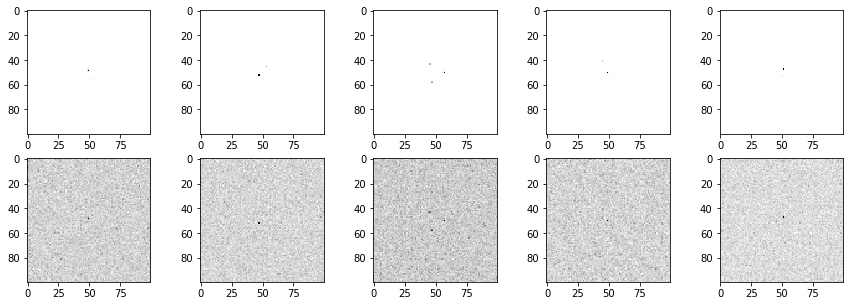

(8000, 100, 100) (2000, 100, 100) (8000, 100, 100) (2000, 100, 100)


In [2]:
indir = './SSI_Projects/jet_notebooks/' #change to appropriate location
fileIN = indir + 'Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5'
f = h5py.File(fileIN)

jet_images = np.array(f.get('jetImage'))
jet_images = preprocess(jet_images)

noisy_jet_images = noise(jet_images)

print(noisy_jet_images.shape, jet_images.shape)

train_data = jet_images[:8000]
test_data = jet_images[8000:]
noisy_train_data = noisy_jet_images[:8000]
noisy_test_data = noisy_jet_images[8000:]

display(jet_images, noisy_jet_images)
print(train_data.shape, test_data.shape, noisy_train_data.shape, noisy_test_data.shape)

In [3]:
train_data = np.expand_dims(train_data, axis =3)
test_data = np.expand_dims(test_data, axis =3)
noisy_train_data = np.expand_dims(noisy_train_data, axis =3)
noisy_test_data = np.expand_dims(noisy_test_data, axis =3)

In [4]:
input_img = Input(shape=(100, 100, 1))
x = Conv2D(32, 3, activation='relu', padding='same')(input_img)
x = BatchNormalization()(x) 
x = MaxPooling2D(2, padding='same')(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x) 
encoded = MaxPooling2D(2, padding='same')(x)

x = Conv2D(64, 3, activation='relu', padding='same')(encoded)
x = BatchNormalization()(x) 
x = UpSampling2D(2)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x) 
x = UpSampling2D(2)(x)
decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)

In [5]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy')

#### Method 1: without using generators (simple)

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', mode = 'min',min_delta = 1e-3, patience=5, restore_best_weights=True)

history = autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
    callbacks=[early_stopping]
)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 8s 959us/sample - loss: 0.6439 - val_loss: 1.2945
Epoch 2/100
8000/8000 [==============================] - 3s 398us/sample - loss: 0.3921 - val_loss: 0.2762
Epoch 3/100
8000/8000 [==============================] - 3s 392us/sample - loss: 0.1669 - val_loss: 0.0704
Epoch 4/100
8000/8000 [==============================] - 3s 390us/sample - loss: 0.0705 - val_loss: 0.0401
Epoch 5/100
8000/8000 [==============================] - 3s 390us/sample - loss: 0.0358 - val_loss: 0.0238
Epoch 6/100
8000/8000 [==============================] - 3s 393us/sample - loss: 0.0211 - val_loss: 0.0156
Epoch 7/100
8000/8000 [==============================] - 3s 392us/sample - loss: 0.0138 - val_loss: 0.0108
Epoch 8/100
8000/8000 [==============================] - 3s 390us/sample - loss: 0.0097 - val_loss: 0.0080
Epoch 9/100
8000/8000 [==============================] - 3s 396us/sample - loss: 0.0072 - val_lo

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

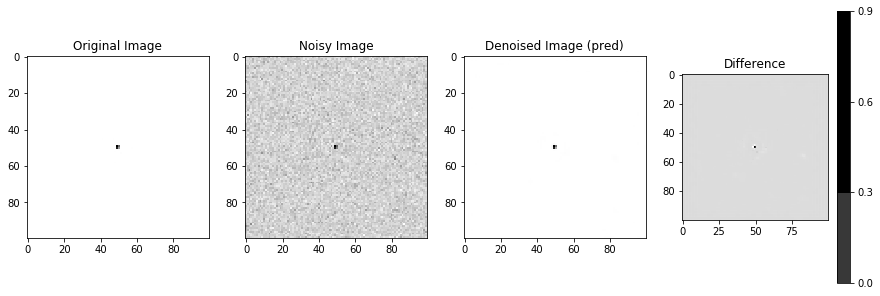

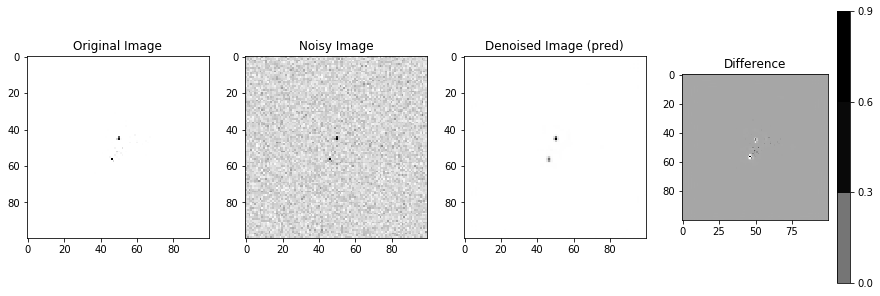

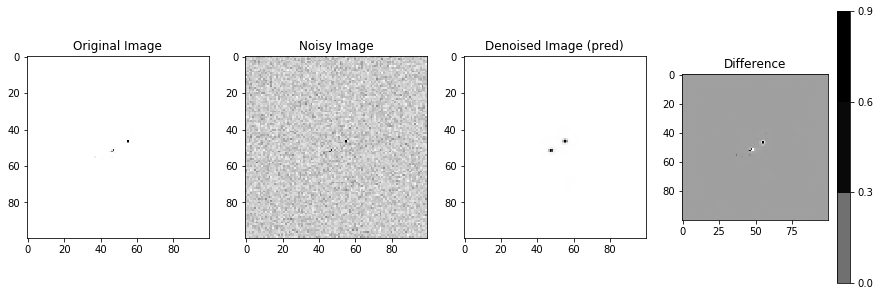

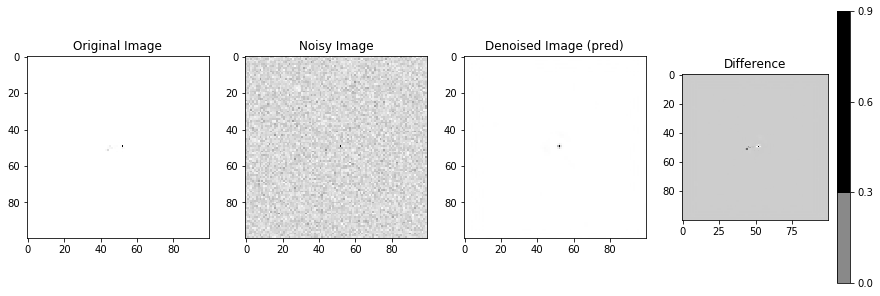

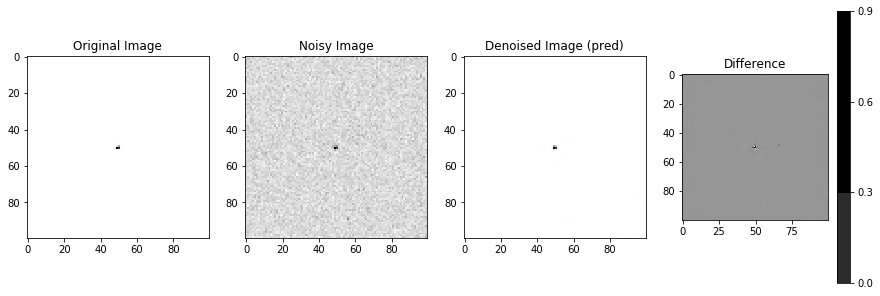

In [7]:
predictions = autoencoder.predict(noisy_test_data)
plotting(test_data, noisy_test_data, predictions, seed = 50)

#### Method 2: using ImageDataGenerator and fitting the generator

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

bsize = 32
aug = ImageDataGenerator(rotation_range=20, horizontal_flip=True)
# don't use too much augmentation becuase the jet images are too sparse to handle the smudging

In [7]:
%%time
early_stopping = EarlyStopping(monitor='val_loss', mode = 'min',min_delta = 5e-3, patience=5, restore_best_weights=True)
history = autoencoder.fit_generator(
    aug.flow(noisy_train_data, train_data, batch_size=bsize),
    steps_per_epoch=len(noisy_train_data) // bsize,
    epochs=50,
    validation_data=(noisy_test_data, test_data), 
    callbacks=[early_stopping]
)


W0817 17:22:21.159137 140367591569216 deprecation.py:323] From <timed exec>:7: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.
W0817 17:22:21.190839 140367591569216 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 250 steps, validate on 2000 samples
Epoch 1/50
250/250 [==============================] - 10s 40ms/step - loss: 0.6608 - val_loss: 0.7623
Epoch 2/50
250/250 [==============================] - 6s 24ms/step - loss: 0.4018 - val_loss: 0.1782
Epoch 3/50
250/250 [==============================] - 6s 24ms/step - loss: 0.1794 - val_loss: 0.1059
Epoch 4/50
250/250 [==============================] - 6s 24ms/step - loss: 0.0771 - val_loss: 0.0544
Epoch 5/50
250/250 [==============================] - 6s 25ms/step - loss: 0.0391 - val_loss: 0.0301
Epoch 6/50
250/250 [==============================] - 6s 24ms/step - loss: 0.0230 - val_loss: 0.0192
Epoch 7/50
250/250 [==============================] - 6s 23ms/step - loss: 0.0151 - val_loss: 0.0129
Epoch 8/50
250/250 [==============================] - 6s 25ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 9/50
250/250 [==============================] - 6s 24ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 10/50
250/250 [=======================

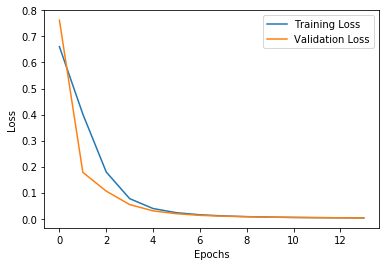

In [8]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

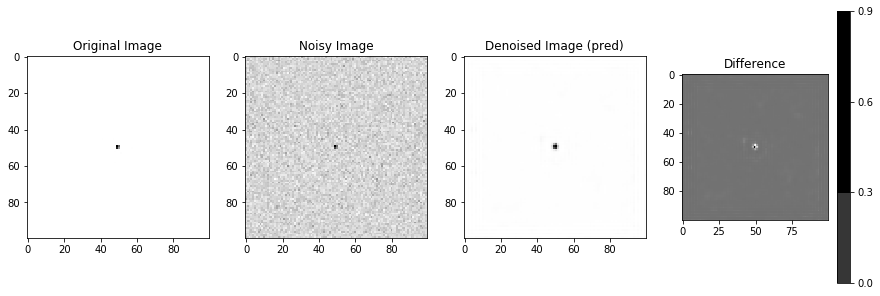

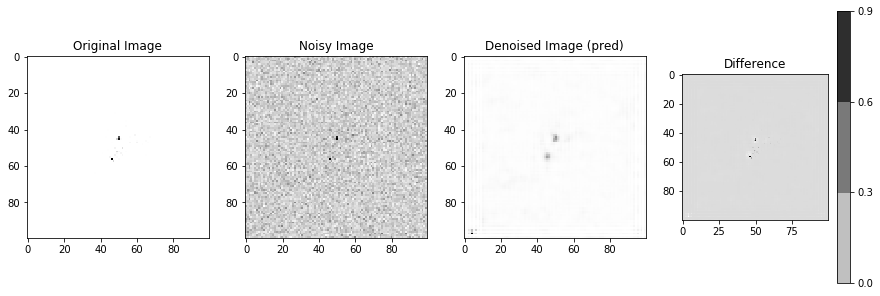

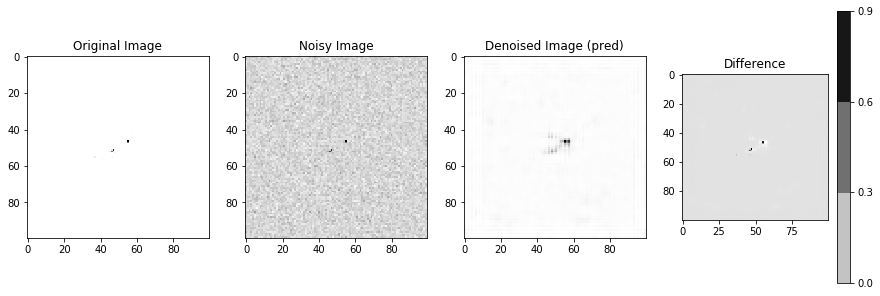

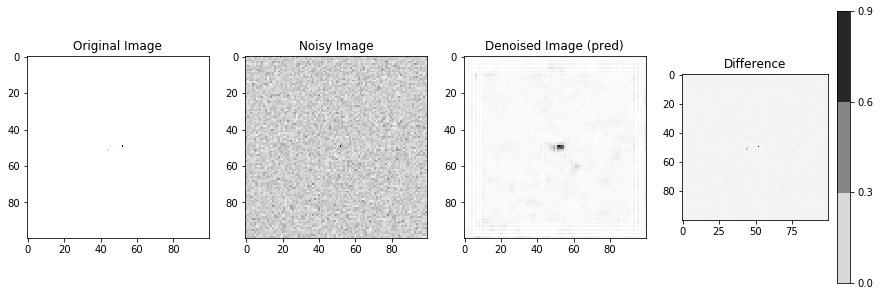

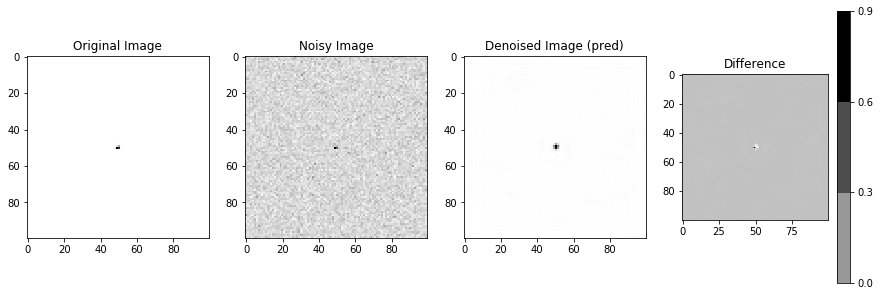

In [9]:
predictions = autoencoder.predict(noisy_test_data)
plotting(test_data, noisy_test_data, predictions, seed = 50)